In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


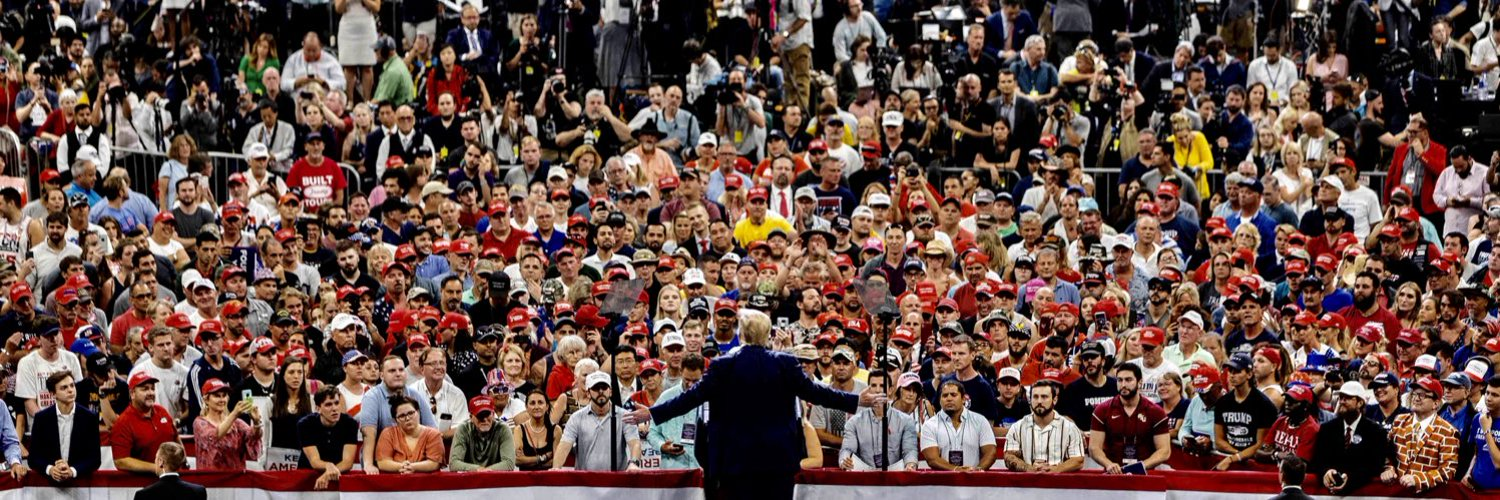

In [15]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/Colab Projects/trump/djt-twitterheader.jpeg') 

Source: [Header photo of Donald Trump's Twitter account](https://twitter.com/realDonaldTrump/header_photo)

## Introduction

Out of all the social media platforms in operation today, Twitter is potentially the best at being able to quickly find out what's happening in the world. A constant stream of once 140, but recently 280-character messages show what people think about sports, entertainment, politics, and more. At least within the context of the U.S.A., Twitter has been used increasingly in the past few years by politicians to give the public an idea of what actually goes on in government --- however opinionated their statements may seem. With that in mind, there is likely no Twitter account followed more closely today than that of our very own 45th President, Donald Trump. 

Trump's timeline provides for a relatively public view of how he aims to run the country and convey the office of the presidency --- as it should. Regardless of what he says (good or bad), CNN, Fox News, the Washington Post, and other news organizations spend considerable effort giving his tweets attention and debating the resulting impact on the country. It is no secret that President Trump is a Republican and wastes no time speaking out against celebrities, congressmen, senators, governors, aspiring candidates, and others on the other side of political aisle. It is also fairly obvious to see that President Trump's tweets grab headlines and that he rushes to defend himself on the platform in the face of questionable decisions or damaging legal investigations.

This notebook will attempt to go through the entirety of Donald Trump's Twitter timeline and provide insights into how he uses the platform. At the end, just for fun, there will also be a generator that uses a pre-trained language model to construct new tweets of Trump's likeness.   

## Cleanup & First Insights

In [25]:
import pandas as pd
import numpy as np
import os
import time 
import re
from datetime import datetime

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import cufflinks as cf

pd.set_option('display.max_colwidth', -1)
pio.renderers.default = 'colab'
cf.go_offline()

windows_path = '/Users/Aniruddha/Desktop/projects/trump/djt-06032020.csv'
mac_path = '/Users/aniruddhaprabhu/Library/Mobile Documents/com~apple~CloudDocs/Data/trump/csv/djt-06032020.csv'
gdrive_path = '/content/drive/My Drive/Colab Projects/trump/csv/djt-06092020-revised.csv'

tweets = pd.read_csv(gdrive_path)

# tweets[tweets['created_at'] == '13']
# tweets[34790:34795]
# tweets.drop([34645, 34646, 34769, 34770, 34794,34795], inplace=True)

tweets.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter Media Studio,https://t.co/lEwOBtMVUf,Wed Jun 10 02:14:00 +0000 2020,10211,29725,False,1.270000e+18
1,Twitter Media Studio,https://t.co/FKGagCwNZ2,Wed Jun 10 02:10:06 +0000 2020,16500,47430,False,1.270000e+18
2,Twitter for iPhone,“Republican AGs come out in force against defunding police” https://t.co/AAJiCHsqTp,Wed Jun 10 02:02:15 +0000 2020,11833,42168,False,1.270000e+18
3,Twitter for iPhone,"Thank you George, great honor! https://t.co/1WzkcvLpnR",Wed Jun 10 00:45:02 +0000 2020,23360,109678,False,1.270000e+18
4,Twitter for iPhone,"Great work in the Republican Senate on some big nominees. Still 154 to go, hope they don’t adjourn until the job is done! @senatemajldr",Tue Jun 09 18:34:51 +0000 2020,21383,97813,False,1.270000e+18


In [26]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36257 entries, 0 to 36256
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   source          36257 non-null  object 
 1   text            36257 non-null  object 
 2   created_at      36257 non-null  object 
 3   retweet_count   36257 non-null  int64  
 4   favorite_count  36257 non-null  int64  
 5   is_retweet      36199 non-null  object 
 6   id_str          36257 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.9+ MB


In [27]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%a %b %d %H:%M:%S %z %Y')
tweets['created_at'].head()

0   2020-06-10 02:14:00+00:00
1   2020-06-10 02:10:06+00:00
2   2020-06-10 02:02:15+00:00
3   2020-06-10 00:45:02+00:00
4   2020-06-09 18:34:51+00:00
Name: created_at, dtype: datetime64[ns, UTC]

The times indicated above are from UTC+0000/Greenwich Median Time/U.K Time. Since Donald Trump resides in the White House and conducts his business around D.C./New York/Florida, it is best to convert those times to Eastern Standard Time/UTC-0500 as a frame of reference for when he tweets.

In [28]:
# tweets['created_at'] = tweets['created_at'].dt.tz_localize('UTC')
tweets['created_at'] = tweets['created_at'].dt.tz_convert('US/Eastern')
tweets['created_at'].head()

0   2020-06-09 22:14:00-04:00
1   2020-06-09 22:10:06-04:00
2   2020-06-09 22:02:15-04:00
3   2020-06-09 20:45:02-04:00
4   2020-06-09 14:34:51-04:00
Name: created_at, dtype: datetime64[ns, US/Eastern]

Since this notebook aims to examine tweets themselves and not the content of any external sources, the URLs need to be removed from the text. For instance, Mr. Trump occasionally makes tweets that include direct links to external media or tweets from other accounts, which are irrelevent to what he actually types out. Additionally, some of his tweets include only the links & nothing else, so those tweets need to be deleted entirely from the dataframe.  

In [29]:
for index, row in tweets.iterrows():
    tweets['text'][index] = ' '.join([word for word in tweets['text'][index].split() if 'http' not in word])
    
tweets.drop(tweets[tweets['text'] == ''].index, inplace=True)
len(tweets)

35726

In [30]:
mtweet_starting = tweets[tweets['text'].str.endswith('..') & ~(tweets['text'].str.startswith('..'))].index
mtweet_middle = tweets[tweets['text'].str.startswith('..') & tweets['text'].str.endswith('..')].index
mtweet_ending = tweets[tweets['text'].str.startswith('..') & ~(tweets['text'].str.endswith('..'))].index

tweets.drop(mtweet_starting, inplace=True)
tweets.drop(mtweet_middle, inplace=True)
tweets.drop(mtweet_ending, inplace=True)
len(tweets)

33004

In [31]:
tweets = tweets[~tweets['text'].str.startswith('RT')]
len(tweets)

28585

## Tweet Statistics

In [32]:
sources = tweets['source'].value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Pie(labels=sources.index.values, values=sources['source'])])
fig.update_layout(
    title_text="Tweet Sources for Donald Trump")
fig.show()

In [33]:
days = tweets['created_at'].dt.day_name().value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Bar(x=days.index.values, y=days['created_at'])])
fig.update_layout(
    title_text="Weekly Tweet Distribution of Donald Trump", 
    xaxis=dict(title='Day of Week'),
    yaxis=dict(title='Number of Tweets'))
fig.show()

It's pretty obvious to see here that Mr. Trump tweets pretty evenly on the weekdays, but tends to cut down on the weekends. Now on to the time of day...

In [34]:
hour_of_days = tweets['created_at'].dt.hour.value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Bar(x=hour_of_days.index.values, y=hour_of_days['created_at'])])
fig.update_layout(
    title_text="Intra-day Tweet Distribution of Donald Trump", 
    xaxis=dict(title='Hour of Day (24-HR time)'),
    yaxis=dict(title='Number of Tweets'))
fig.show()

In [35]:
tweets['total_engagements'] = tweets['retweet_count'] + tweets['favorite_count'].astype(float)
largest = tweets.nlargest(10, 'total_engagements')[['text','created_at', 'total_engagements']]

for index, row in largest.iterrows():
    print('Text:', row['text'] + '\n' + 
          'Created At:', str(row['created_at']) + '\n' +
          'Total Engagements:', row['total_engagements'], '\n')

Text: A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!
Created At: 2019-08-02 13:41:30-04:00
Total Engagements: 1131177.0 

Text: The United States of America will be designating ANTIFA as a Terrorist Organization.
Created At: 2020-05-31 12:23:43-04:00
Total Engagements: 1056488.0 

Text: #FraudNewsCNN #FNN
Created At: 2017-07-02 09:21:42-04:00
Total Engagements: 974628.0 

Text: CHINA!
Created At: 2020-05-29 09:01:56-04:00
Total Engagements: 953671.0 

Text: Just spoke to @KanyeWest about his friend A$AP Rocky’s incarceration. I will be calling the very talented Prime Minister of Sweden to see what we can do about helping A$AP Rocky. So many people would like to see this quickly resolved!
Created At: 2019-07-19 16:01:47-04:00
Total Engagements: 944753.0 

Text: All is well! Missiles launched from Iran at two military bases located in Iraq. Assessment of casualties &amp; damages taking place now. So far, so g

## Content Analysis

The next section of this notebook will attempt to quantify this by looking deeper into the content of the tweets. This would include areas such as how much Donald Trump tweets about something and his perception of it (positive or negative).

In [36]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('vader_lexicon')

import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sw = set(stopwords.words('english'))
sid = SentimentIntensityAnalyzer()

def clean_tweet(txt):
    txt = txt.lower()
    txt = [word.strip(string.punctuation) for word in txt.split(' ')]
    txt = ' '.join(txt)
    
    return txt

def get_sentiment(poly):
    if poly >= 0.05:
        return 'positive'
    elif poly <= -0.05: 
        return 'negative' 
    elif poly > -0.05 and poly < 0.05:
        return 'neutral'

tweets['text_clean'] = tweets['text'].apply(lambda tweet: clean_tweet(tweet))
tweets['polarity'] = tweets['text'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])
tweets['sentiment'] = tweets['polarity'].apply(lambda polarity: get_sentiment(polarity))

obama_tweets = tweets[tweets['text_clean'].str.contains('obama')]
obama_tweets.head()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,total_engagements,text_clean,polarity,sentiment
109,Twitter for iPhone,"Sleepy Joe Biden’s 1994 Crime Bill was a total disaster. It was mass incarceration for Black people, many of them innocent. I did Criminal Justice Reform, something Obama &amp; Biden didn’t even try to do - &amp; couldn’t do even if they did try. Biden can never escape his Crime Bill!",2020-06-04 21:57:24-04:00,36386,127797,False,1.270000e+18,164183.0,sleepy joe biden’s 1994 crime bill was a total disaster it was mass incarceration for black people many of them innocent i did criminal justice reform something obama amp biden didn’t even try to do amp couldn’t do even if they did try biden can never escape his crime bill,-0.8888,negative
114,Twitter for iPhone,"The problem with asking for someone to give you a letter of resignation, which you do as a courtesy to help them save face, is that it is then harder to say you fired them. I did fire James Mattis. He was no good for Obama, who fired him also, and was no good for me!",2020-06-04 19:20:20-04:00,23195,99204,False,1.270000e+18,122399.0,the problem with asking for someone to give you a letter of resignation which you do as a courtesy to help them save face is that it is then harder to say you fired them i did fire james mattis he was no good for obama who fired him also and was no good for me,-0.6114,negative
169,Twitter for iPhone,"Thank you Ted. They got caught cold, but this should never be allowed to happen to an incoming administration again - Spied on. Makes Watergate look like small potatoes! OBAMAGATE!",2020-06-03 06:16:37-04:00,17254,56610,False,1.270000e+18,73864.0,thank you ted they got caught cold but this should never be allowed to happen to an incoming administration again spied on makes watergate look like small potatoes obamagate,0.6792,positive
265,Twitter for iPhone,.@Facebook CEO Mark Zuckerberg is today criticizing Twitter. “We have a different policy than Twitter on this. I believe strongly that Facebook shouldn’t be the arbiter of truth of everything that people say online.” Did Twitter criticize Obama for his “you can keep your Dr.”?,2020-05-28 20:48:59-04:00,38191,160701,False,1.270000e+18,198892.0,facebook ceo mark zuckerberg is today criticizing twitter “we have a different policy than twitter on this i believe strongly that facebook shouldn’t be the arbiter of truth of everything that people say online.” did twitter criticize obama for his “you can keep your dr.”,-0.1779,negative
291,Twitter for iPhone,Trump on Russia Hoax: ‘When the Papers Come Out’ We Will Learn Obama ‘Knew Everything’,2020-05-28 07:53:00-04:00,20440,68835,False,1.270000e+18,89275.0,trump on russia hoax ‘when the papers come out’ we will learn obama ‘knew everything’,-0.2732,negative


In [37]:
sentiments = obama_tweets['sentiment'].value_counts().to_frame()

pio.renderers.default = 'colab'
fig = go.Figure(data=[go.Pie(labels=sentiments.index.values, values=sentiments['sentiment'])])
fig.update_layout(
    title_text="Sentiment of Trump's Tweets mentioning Obama")
fig.show()

The tweets that mention former president Barack Obama appear to be positive 34.8% of the time --- an odd figure given Trump's public opinion of him. However, there is a noticeable plurality of negative sentiment.

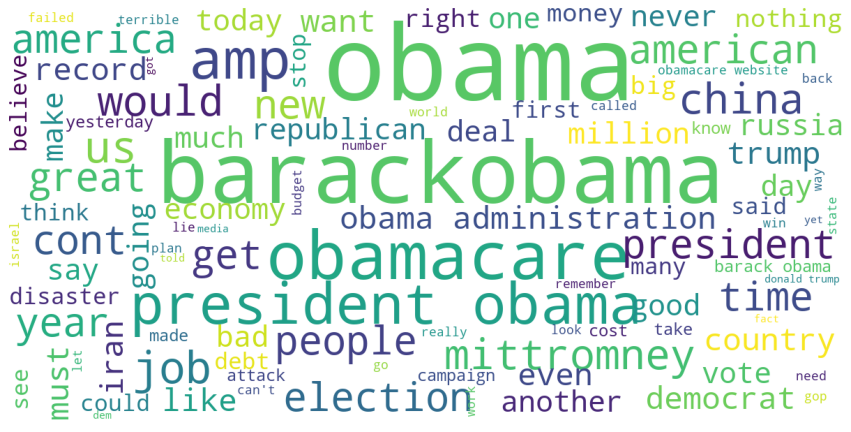

In [38]:
def show_wordcloud(data, column):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 50, 
        scale = 3,
        random_state = 42, 
        stopwords = sw
    ).generate(" ".join([i for i in data[column]]))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(obama_tweets, 'text_clean')

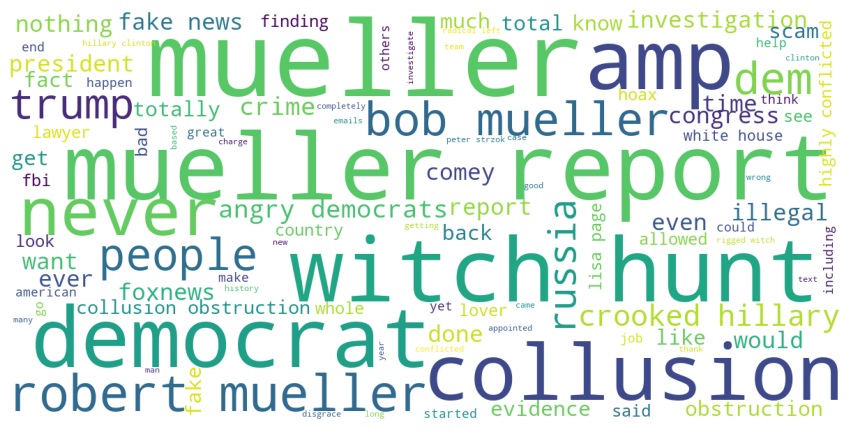

In [39]:
mueller_tweets = tweets[tweets['text_clean'].str.contains('mueller')]
show_wordcloud(mueller_tweets, 'text_clean')

As expected, the phrases 'witch hunt' and 'collusion' are fairly large here since these are Trump's go-to attacks on the Robert Mueller's investigation into both his & Russia's involvement in the 2016 election.

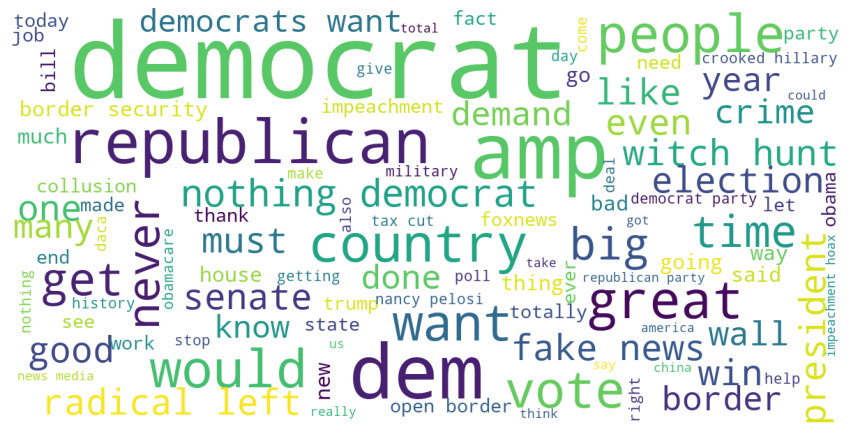

In [40]:
dem_tweets = tweets[tweets['text_clean'].str.contains('dem')]
show_wordcloud(dem_tweets, 'text_clean')

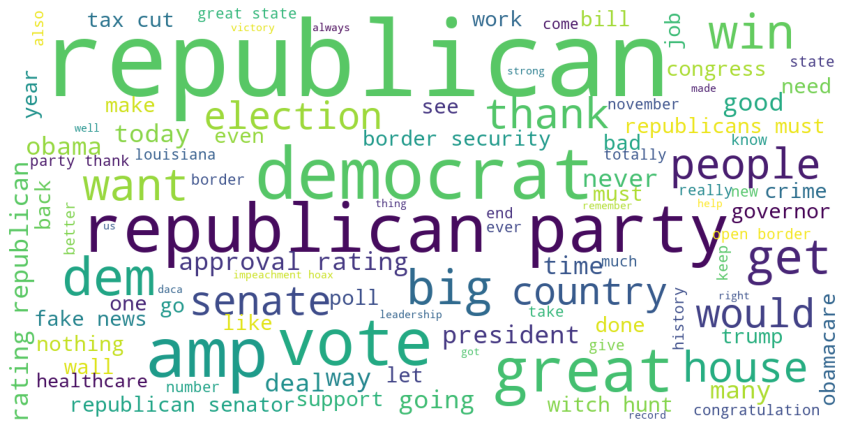

In [41]:
gop_tweets = tweets[tweets['text_clean'].str.contains('republican')]
show_wordcloud(gop_tweets, 'text_clean')

## Just for Fun: Tweet Generator

### FastAI LSTM

In [43]:
from fastai import *
from fastai.text import *
from sklearn.model_selection import train_test_split

train_tweets, test_tweets = train_test_split(tweets, test_size=0.1, random_state=7)
mac_models_path = '/Users/aniruddhaprabhu/Desktop/Data/trump'
colab_models_path = ''

lmdb = TextLMDataBunch.from_df(path=colab_models_path, train_df=train_tweets, valid_df=test_tweets, text_cols='text')
lml = language_model_learner(data=lmdb, arch=AWD_LSTM, pretrained=True, drop_mult=0.5)

In [44]:
lml.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


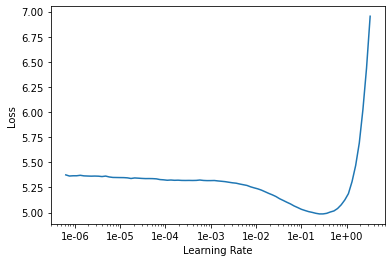

In [45]:
lml.recorder.plot()

In [46]:
lml.fit(epochs=10, lr=5e-2, wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,4.332075,3.898566,0.310115,01:10
1,3.987193,3.814166,0.321945,01:10
2,3.832098,3.806376,0.324319,01:10
3,3.760472,3.798441,0.327173,01:10
4,3.719586,3.823261,0.326445,01:10
5,3.686052,3.831538,0.325881,01:10
6,3.657216,3.857721,0.325235,01:10
7,3.626501,3.850945,0.328043,01:10
8,3.596703,3.876728,0.327350,01:10
9,3.597076,3.870887,0.330122,01:10


In [47]:
generated_tweets = []

for twt in range(30):
    sample = lml.predict(text='', n_words=30, temperature=0.7)
    sample_cleaned = [sentence for sentence in sample.split('xxbos') if sentence not in ['', ' ']]
    generated_tweets.append(sample_cleaned[0])
    
generated_tweets

[' Thank you Kanye West , who is a champion for the Koch Brothers , who are very smart and even very smart , and are',
 ' Thank you Steve Bannon . Great guy , who is a very tough man , thanks . ',
 " Congratulations to Steve Bannon on the harris 's endorsement ! ",
 ' The Wall Street Journal Poll Poll , PPP , a great time , thank you ! ',
 ' " Thank you Kanye West Peter Strzok . We all know him . He is one of the most generous people in the',
 ' Thank you for your nice words on the Inauguration . We are proud to be working hard ! ',
 ' President Obama just told me that President Xi of Japan and Japan are not happy ! ',
 ' Thank you Bobby Knight ! ',
 ' The Democrats have been asking for a major ban on Republicans . Republicans and Republicans are a House tomorrow . Watch this !',
 ' “ The Mexican Attorney Generel of the United States ” , Sgt . Robert Mueller , is a Whistleblower .',
 " The Obama Administration does n't need to be a GREAT U.S. We have a great meeting ! Not just one thin

In [48]:
num_words = 0

for t in tweets['text_clean']:
    num_words += len(t.split(' '))
    
num_words / len(tweets)

19.502571278642645

In [54]:
lml.predict(text='Obama', n_words=30, temperature=0.5)

'Obama ’s Administration has been killing our military and our military , and we are monitoring the labor program in the United States . He is a'

### GPT-2 Medium (345M parameters)

In [55]:
!git clone https://github.com/openai/gpt-2.git

Cloning into 'gpt-2'...
remote: Enumerating objects: 230, done.
remote: Total 230 (delta 0), reused 0 (delta 0), pack-reused 230
Receiving objects: 100% (230/230), 4.38 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [56]:
%cd gpt-2/
!pip install tensorflow-gpu==1.15
!pip install -r requirements.txt
!python3 "/content/gpt-2/download_model.py" 345M

/content/gpt-2
     |████████████████████████████████| 411.5MB 42kB/s 
     |████████████████████████████████| 3.8MB 31.9MB/s 
     |████████████████████████████████| 512kB 30.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f121d24250a3c62c9d87afcbecbf9dda209ca5f2687d2d1ab76ccdd57a55f8e2
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    

Fetching checkpoint: 1.00kit [00:00, 946kit/s]                                                      
Fetching encoder.json: 1.04Mit [00:00, 38.4Mit/s]                                                   
Fetching hparams.json: 1.00kit [00:00, 1.11Mit/s]                                                   
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:37, 38.3Mit/s]                                 
Fetching model.ckpt.index: 11.0kit [00:00, 9.04Mit/s]                                               
Fetching model.ckpt.meta: 927kit [00:00, 34.9Mit/s]                                                 
Fetching vocab.bpe: 457kit [00:00, 35.1Mit/s]                                                       


In [0]:
# Code to generate corpus of Trump tweets if needed to a text file, filters out retweets.
# ---This step already completed in the tweets dataframe during cleanup step earlier in the notebook.
#
# djt_corpus = tweets[~tweets['text'].str.startswith('RT')]['text']
# pd.set_option('display.max_colwidth', -1)

# for t in (('Tweet: ' + djt_corpus[:10000])[::-1]): 
#     textfile = open('djtcorpus_06032020.txt', 'a')
#     textfile.write(t + '\n')
#     textfile.close()
#     print(t)

In [59]:
# Modify the interactive samples script in gpt-2/script by making a variable to store some of the text column from the tweets dataframe 
# and feed this to the tokenizer at the end. Also remove the for loops at the end and tune parameters to your liking. 
# Then run the script as below to generate some samples. 
!python3 "/content/gpt-2/src/gpt2_samples_script.py"


2020-06-15 19:19:40.761482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-15 19:19:40.766015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-15 19:19:40.766873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2020-06-15 19:19:40.787803: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-06-15 19:19:40.994851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-06-15 19:19:41.084631: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

## Concluding Thoughts
From just the provided data, it was fairly easy to get an idea of Trump's general tweeting behavior. As expected, President Trump feels negatively towards subjects that involve Democrats and positive towards subjects that involve the GOP/Republicans. Despite the language model only giving a baseline accuracy of just over 30%, the resulting generated tweets do in fact seem like something that Trump would put out, grammar and punctuation mistakes notwithstanding.

For further investigation, it would have been nice to have data regarding the number of replies/comments to his tweets. Even though he rarely goes back-and-forth with other users on the platform, this could give a better understanding of how many people interact with him. Additionally, a dataset of Trump's follower counts would help get a sense of his popularity over time and match growth spikes to various news-worthy events.